<a href="https://colab.research.google.com/github/MahanandiRajiniYadav/curricula/blob/main/Sepsis_Detection_Medallion_Architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
# Cell 1: Install PySpark and Initialize Session
# ---------------------------------------------------------
# This sets up the environment to run the "Automated Medallion Architecture"
# described in the document[cite: 17, 54].

!pip install pyspark -q

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lag, when, lit, current_timestamp
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Initialize Spark Session (Simulating the Databricks Runtime)
spark = SparkSession.builder \
    .appName("SepsisDetection_MedallionArchitecture") \
    .master("local[*]") \
    .getOrCreate()

print("✅ Spark Session Initialized. Ready for Medallion Pipeline.")

✅ Spark Session Initialized. Ready for Medallion Pipeline.


In [15]:
# Cell 2: Bronze Layer - Ingest Raw Sensor Data
# ---------------------------------------------------------
# Simulates "Raw Ingestion" of continuous streams from wearable biosensors.

def generate_synthetic_data(num_patients=5, readings_per_patient=20):
    data = []
    base_time = datetime.now() - timedelta(hours=24)

    for pid in range(1, num_patients + 1):
        # Normal baseline temp
        current_temp = 36.5
        for i in range(readings_per_patient):
            timestamp = base_time + timedelta(hours=i)

            # SIMULATING A SEPSIS EVENT FOR PATIENT 3
            # PDF mentions "Sudden temperature spikes" as a key indicator [cite: 20]
            if pid == 3 and i > 15:
                current_temp += np.random.uniform(0.8, 1.5) # Rapid spike
            else:
                current_temp += np.random.uniform(-0.2, 0.2) # Normal fluctuation

            # Add occasional "sensor noise" (to be cleaned in Silver layer)
            final_temp = None if np.random.rand() > 0.95 else round(current_temp, 2)

            data.append((f"Patient_{pid}", timestamp, final_temp, "SteadyTemp_Biosensor"))

    return data

# Create DataFrame
raw_data = generate_synthetic_data()
columns = ["patient_id", "event_time", "temperature_c", "source_device"]

df_bronze = spark.createDataFrame(raw_data, columns)

# Save as Parquet (Simulating Delta Lake Bronze Table)
df_bronze.write.mode("overwrite").parquet("/content/medallion/bronze_sensors")

print("✅ Bronze Layer: Raw sensor data ingested successfully.")
df_bronze.show(5)

✅ Bronze Layer: Raw sensor data ingested successfully.
+----------+--------------------+-------------+--------------------+
|patient_id|          event_time|temperature_c|       source_device|
+----------+--------------------+-------------+--------------------+
| Patient_1|2026-01-29 07:02:...|        36.62|SteadyTemp_Biosensor|
| Patient_1|2026-01-29 08:02:...|        36.64|SteadyTemp_Biosensor|
| Patient_1|2026-01-29 09:02:...|        36.55|SteadyTemp_Biosensor|
| Patient_1|2026-01-29 10:02:...|        36.69|SteadyTemp_Biosensor|
| Patient_1|2026-01-29 11:02:...|        36.55|SteadyTemp_Biosensor|
+----------+--------------------+-------------+--------------------+
only showing top 5 rows


In [17]:
# Cell 3: Silver Layer - Transformation & Sepsis Logic
# ---------------------------------------------------------
# Cleaning data and identifying "Sudden Spikes"[cite: 56, 20].

# 1. Load Bronze Data
df_silver_input = spark.read.parquet("/content/medallion/bronze_sensors")

# 2. Define Window for Time-Series Analysis (Previous Temp vs Current Temp)
window_spec = Window.partitionBy("patient_id").orderBy("event_time")

# 3. Apply Clinical Rules
df_silver = df_silver_input \
    .dropna(subset=["temperature_c"]) \
    .withColumn("prev_temp", lag("temperature_c").over(window_spec)) \
    .withColumn("temp_change", col("temperature_c") - col("prev_temp")) \
    .withColumn("is_fever", col("temperature_c") >= 38.0) \
    .withColumn("is_sudden_spike", col("temp_change") >= 1.0) \
    .withColumn("sepsis_warning",
                (col("is_fever") | col("is_sudden_spike")) & (col("temperature_c") > 37.5))

# Filter for relevant columns for the Silver Table
df_silver_clean = df_silver.select(
    "patient_id", "event_time", "temperature_c", "temp_change", "is_sudden_spike", "sepsis_warning"
)

# Save as Parquet (Simulating Delta Lake Silver Table)
df_silver_clean.write.mode("overwrite").parquet("/content/medallion/silver_clinical")

print("✅ Silver Layer: Clinical rules applied. Sudden spikes identified.")
df_silver_clean.filter(col("sepsis_warning") == True).show()

✅ Silver Layer: Clinical rules applied. Sudden spikes identified.
+----------+--------------------+-------------+------------------+---------------+--------------+
|patient_id|          event_time|temperature_c|       temp_change|is_sudden_spike|sepsis_warning|
+----------+--------------------+-------------+------------------+---------------+--------------+
| Patient_3|2026-01-29 23:02:...|        38.02| 1.480000000000004|           true|          true|
| Patient_3|2026-01-30 00:02:...|        38.82|0.7999999999999972|          false|          true|
| Patient_3|2026-01-30 01:02:...|         39.9|1.0799999999999983|           true|          true|
| Patient_3|2026-01-30 02:02:...|        41.13| 1.230000000000004|           true|          true|
+----------+--------------------+-------------+------------------+---------------+--------------+



--- 🚨 CRITICAL SEPSIS ALERTS  ---
+----------+--------------------+-------------+------------------+---------------+--------------+
|patient_id|          event_time|temperature_c|       temp_change|is_sudden_spike|sepsis_warning|
+----------+--------------------+-------------+------------------+---------------+--------------+
| Patient_3|2026-01-30 02:02:...|        41.13| 1.230000000000004|           true|          true|
| Patient_3|2026-01-30 01:02:...|         39.9|1.0799999999999983|           true|          true|
| Patient_3|2026-01-30 00:02:...|        38.82|0.7999999999999972|          false|          true|
| Patient_3|2026-01-29 23:02:...|        38.02| 1.480000000000004|           true|          true|
+----------+--------------------+-------------+------------------+---------------+--------------+

✅ Gold Layer: Dashboard generated.


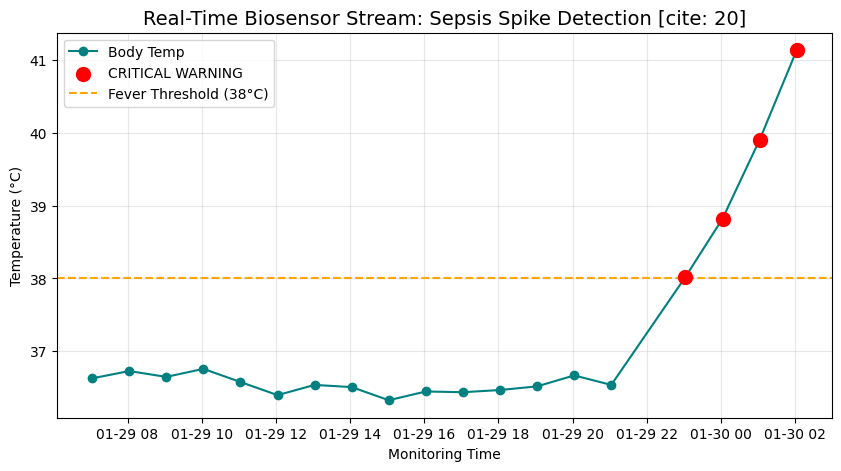

In [18]:
# Cell 4: Gold Layer - Aggregation & Visualization
# ---------------------------------------------------------
# Aggregating data for "real-time sepsis monitoring dashboards".

# 1. Load Silver Data
df_gold_input = spark.read.parquet("/content/medallion/silver_clinical")

# 2. Filter for Critical Alerts (Simulating the alert in source [3])
critical_alerts = df_gold_input.filter(col("sepsis_warning") == True).orderBy(col("event_time").desc())

print("--- 🚨 CRITICAL SEPSIS ALERTS  ---")
critical_alerts.show(5)

# 3. Visualize Patient 3 (The Simulated Sepsis Case)
# We convert to Pandas for plotting (simulating the Dashboard view)
pdf_patient_3 = df_gold_input.filter(col("patient_id") == "Patient_3").toPandas()

plt.figure(figsize=(10, 5))
plt.plot(pdf_patient_3['event_time'], pdf_patient_3['temperature_c'], marker='o', linestyle='-', color='teal', label='Body Temp')

# Highlight Sepsis Spikes
spikes = pdf_patient_3[pdf_patient_3['sepsis_warning'] == True]
plt.scatter(spikes['event_time'], spikes['temperature_c'], color='red', s=100, label='CRITICAL WARNING', zorder=5)

plt.axhline(y=38.0, color='orange', linestyle='--', label='Fever Threshold (38°C)')
plt.title("Real-Time Biosensor Stream: Sepsis Spike Detection [cite: 20]", fontsize=14)
plt.ylabel("Temperature (°C)")
plt.xlabel("Monitoring Time")
plt.legend()
plt.grid(True, alpha=0.3)

print("✅ Gold Layer: Dashboard generated.")
plt.show()